# Red Wine Quality

Kaggle link: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

Link Ex1:
https://www.kaggle.com/code/alessandromajumba/regression


https://wandb.ai/ales-2000-09/simple_regression

In [2]:
""" # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import wandb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session """

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


First, we need to import Pytorch

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import wandb
import torch
from torch import nn
from torch import optim
from torch.utils import data

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Label")

import wandb
wandb.login(key=secret_value_0)
wandb.init(project='simple_regression')

wandb: Currently logged in as: ales-2000-09. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Data Processing

In [4]:
train_data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')
train_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We need to separate features from target

In [5]:
n_train = train_data.shape[0]
all_features = train_data.iloc[:, 1:-1]
all_features = all_features.apply(lambda x: (x - x.mean()) / (x.std()))
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
train_features

tensor([[ 0.9616, -1.3910, -0.4531,  ...,  1.2882, -0.5790, -0.9599],
        [ 1.9668, -1.3910,  0.0434,  ..., -0.7197,  0.1289, -0.5846],
        [ 1.2967, -1.1857, -0.1694,  ..., -0.3311, -0.0481, -0.5846],
        ...,
        [-0.0995, -0.7237, -0.1694,  ...,  0.7053,  0.5419,  0.5415],
        [ 0.6544, -0.7750, -0.3822,  ...,  1.6769,  0.3059, -0.2092],
        [-1.2165,  1.0217,  0.7527,  ...,  0.5110,  0.0109,  0.5415]])

In [6]:
trains_labels = train_data.quality.values.reshape(-1, 1)
trains_labels_den = trains_labels

In [7]:
trains_mean = trains_labels.mean()
trains_std = trains_labels.std()
trains_labels = (trains_labels - trains_mean) / trains_std
train_labels = torch.tensor(trains_labels, dtype=torch.float32)
train_labels

tensor([[-0.7878],
        [-0.7878],
        [-0.7878],
        ...,
        [ 0.4508],
        [-0.7878],
        [ 0.4508]])

## Training

Initialize the weight of the linear regression

In [8]:
n_features = train_data.shape[1]-2
linear_weights = torch.randn(n_features, 1,  dtype=torch.float32, requires_grad=True)
bias = torch.zeros(1, requires_grad=True)

Training loop

# Implementation 1

In [9]:
# num_iterations = 1000 #512
# lr = 1e-3
# for i in range(num_iterations):
#     # Calculate model predictions
#     predictions = torch.mm(train_features, linear_weights) + bias
    
#     # Calculate the cost function (mean square error)
#     loss = torch.mean((predictions - train_labels) ** 2)
    
#     # Calculate the gradient
#     loss.backward()
    
#     # Update the weights and bias using the optimizer
#     with torch.no_grad():
#         linear_weights -= lr * linear_weights.grad
#         bias -= lr * bias.grad
    
#     # Resets the gradient
#     linear_weights.grad.zero_()
#     bias.grad.zero_()
    
#     print({'epoch':(i), 'training_loss': (loss.item())})
#     wandb.log({'Loss': loss.item()})
#     wandb.log({'Weights': linear_weights})
#     wandb.log({'Bias:': bias})

# Implementation 2

In [10]:
batch_size =  32  # mini-batchb dimension

# Calculate the numbers of batch
num_batches = n_train // batch_size

num_iterations = 512
lr = 1e-3

# Initialize an empty tensor
predictions = torch.empty((n_train, 1), dtype=torch.float32)

for i in range(num_iterations):
        for batch in range(num_batches):
            start = batch * batch_size
            end = (batch + 1) * batch_size
        
            # Extract the current batch
            batch_features = train_features[start:end]
            batch_labels = train_labels[start:end]
    
            # Calculate model predictions for the mini-batch
            predic = torch.mm(batch_features, linear_weights) + bias
    
            predictions[start:end, :] = predic
    
            # Calculate the cost function (mean square error) for the mini-batch
            loss = torch.mean((predic - batch_labels) ** 2)
    
            # Calculate the gradient
            loss.backward()
    
            # Update the weights and bias using the optimizer
            with torch.no_grad():
                linear_weights -= lr * linear_weights.grad
                bias -= lr * bias.grad
    
            # Resets the gradient
            linear_weights.grad.zero_()
            bias.grad.zero_()
            
        print({'epoch':(i), 'training_loss': (loss.mean()).item()})
        wandb.log({'Loss': loss.item()})
        wandb.log({'Weights': linear_weights})
        wandb.log({'Bias:': bias})

{'epoch': 0, 'training_loss': 3.991724729537964}
{'epoch': 1, 'training_loss': 2.9393906593322754}
{'epoch': 2, 'training_loss': 2.245807647705078}
{'epoch': 3, 'training_loss': 1.7839906215667725}
{'epoch': 4, 'training_loss': 1.4727674722671509}
{'epoch': 5, 'training_loss': 1.2600435018539429}
{'epoch': 6, 'training_loss': 1.1122301816940308}
{'epoch': 7, 'training_loss': 1.0075664520263672}
{'epoch': 8, 'training_loss': 0.9318712949752808}
{'epoch': 9, 'training_loss': 0.875845730304718}
{'epoch': 10, 'training_loss': 0.8333477973937988}
{'epoch': 11, 'training_loss': 0.800287663936615}
{'epoch': 12, 'training_loss': 0.7739174365997314}
{'epoch': 13, 'training_loss': 0.7523717880249023}
{'epoch': 14, 'training_loss': 0.7343699932098389}
{'epoch': 15, 'training_loss': 0.7190220355987549}
{'epoch': 16, 'training_loss': 0.7057008743286133}
{'epoch': 17, 'training_loss': 0.6939584016799927}
{'epoch': 18, 'training_loss': 0.6834696531295776}
{'epoch': 19, 'training_loss': 0.673995494842

Get the real predictions

In [11]:
predictions = ((predictions * trains_std) + trains_mean).detach().numpy().round()
print(predictions)
print(trains_labels_den)

[[5.]
 [5.]
 [5.]
 ...
 [6.]
 [6.]
 [6.]]
[[5]
 [5]
 [5]
 ...
 [6]
 [5]
 [6]]


ground truthground truthOur predictions seem very close to the ground truth!

**To go further**: Stochastic Gradient Descent is not the optimal algorithm in terms of convergeance.
If you are curious, you can read this nice article about an improvement to SGD, momentum and try to implement it: https://distill.pub/2017/momentum/

In [12]:
# Calculate the average of the observed values
y_true_mean = np.mean(trains_labels_den)

# Calculate the sum of the total squares
ss_total = np.sum((trains_labels_den - y_true_mean) ** 2)

# Calculate the sum of the squares of the residuals
ss_residual = np.sum((trains_labels_den - predictions) ** 2)

# Calculate the coefficient of determination R²
r_squared = 1 - (ss_residual / ss_total)
print("R²:", r_squared)

# Calculate the residual error
residuals = trains_labels_den - predictions

# Mean Squared Error
mse = np.mean(residuals ** 2)
print("MSE:", mse)

R²: 0.23140777066073304
MSE: 0.50093808630394


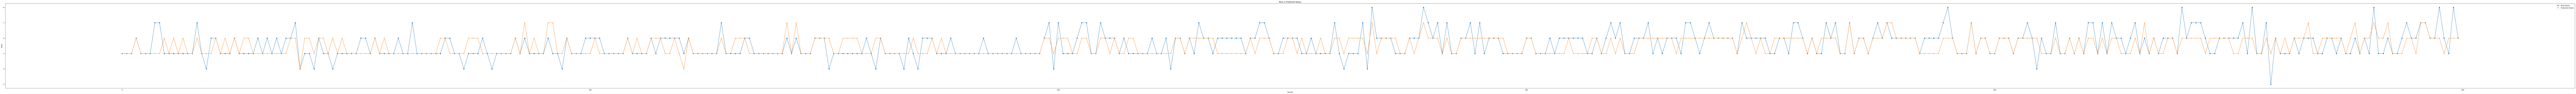

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(300, 10))

plt.plot(trains_labels_den[:500], label='Real Values', marker='o')  # ground truth
plt.plot(predictions[:500], label='Predicted Values', marker='x')  # predicted valuesi

plt.xlabel('Sample')  #  X
plt.ylabel('Value')  # Y
plt.title('Real vs Predicted Values')  # add title
plt.legend()  # add legend

plt.show()